# Global Drifter Program (GDP)

As part of this Notebook, we will use the *GDP historical dataset* to highlight the required steps to preprocess and dataset into a format that can be ingest by the *CloudDrift* library.

## Dataformat module

The `dataformat.py` module contains the class `create_ragged_array` to transform a series of archives into an *Awkward Array* where all variables is stored as a *ragged array*. The module also contains `read_from_netcdf` and `read_from_parquet` to initialize the *Awkward Array* directly from an previously preprocessed archive. Right now, it *only* supports local array but we will soon add the possibility of *lazy-loading* array stored in the Cloud.

In [68]:
import sys
sys.path.insert(0, '../')
from clouddrift import dataformat

The main class of this module is *create_ragged_array* and is used to create a single archive that can be saved to a netCDF or Parquet file. The signature of the class is:

In [69]:
dataformat.create_ragged_array?

Init signature:
dataformat.create_ragged_array(
    indices: list,
    preprocess_func: collections.abc.Callable[[int], xarray.core.dataset.Dataset],
    vars_coords: dict,
    vars_meta: list = [],
    vars_data: list = [],
    rowsize_func: collections.abc.Callable[[int], int] = None,
)
Docstring:      <no docstring>
File:           /nexsan/people/pmiron/projects_mars/clouddrift/clouddrift/dataformat.py
Type:           type
Subclasses:     


## Dataset-specific functions

Since each dataset is different, we have to create specific functions to preprocess the dataset (`preprocess_func`) and return the metadata and data of a single trajectory. This was inspired by the [Pangeo Forge](https://pangeo-forge.readthedocs.io/en/latest/) project. The class *create_ragged_array* will use those functions to create the single archive of ragged arrays. More precisely, it requires:
- a list of indices (or identification number) that will be concatenate into the ragged array format
- a preprecessing function with the following signature:
    - `Signature: preprocess_func(index: int) -> xarray.core.dataset.Dataset`, where the index parameter is an identifier of a trajectory, e.g. the identification number of an Argo float) and returns an *xarray Dataset*. 
- a dictionnary mapping the mandatory coordinates list to the name of those variables in the dataset, e.g.
    coords = {'ids': 'number', 'time': 't', 'longitude': 'lon', 'latitude': 'lat'}
- an optional list of variable names containing metadata information about the trajectory (size: 1 per trajectory)
- an optional list of variable names containing the data along the trajectory (size: number of observations per trajectory)
- an optional funcition that returns directly the number of observation of a trajectory (`Signature: rowsize_func(index: int) -> int`)
    
This function can performs all type of operations, such as formatting the date, changing the type of variables, modifying the metadata, etc. We provide preprocessing function for different datasets in the `data/recipes/` folder. The class also needs to *initially* calculate the sum of all observations. By default, this is performed using `lambda i: self.preprocess_func(i).dims['obs']`. To *speed up* this process, in the situation where a lot of preprocessing are performed, it is possible to provide a second function `rowsize_func`, that returns directly the number of observation of a trajectory (`Signature: rowsize_func(index: int) -> int`)

Finally, we included an function to download (or update) the GDP dataset.

In [70]:
from data import gdp6h

# Download

The download function will store the raw dataset into the `data/raw/` folder specified in the `gdp.py` module. By default `download_gdp_data()` will download the complete GPD dataset (containing 17,324 files as of May 2022) from the AOML `https` server.

**Note**: this Notebook is very similar to the `data-glad.ipynb` Notebook because very few functions have to be created to transform a new dataset. We hope that this will encourage people to use this dataformat and utilize the CloudDrift library.

In [71]:
gdp6h.download?

Signature: gdp6h.download(drifter_ids: list = None, n_random_id: int = None)
Docstring:
Download individual netCDF files from the AOML server

:param drifter_ids [list]: list of drifter to retrieve (Default: all)
:param n_random_id [int]: randomly select n drifter netCDF files
:return drifters_ids [list]: list of retrived drifter
File:      /nexsan/people/pmiron/projects_mars/clouddrift/data/gdp6h.py
Type:      function


It is possible to prodive a list of `drifter_ids` to retrieve a subset and/or specified a integer `n_random_id` to randomly retrieve `n` trajectory. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [88]:
drifter_ids = gdp6h.download(n_random_id=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 768.10it/s]


Once the data downloaded, it is possible to create the ragged array and either save a netCDF, parquet file, or simply output an Awkward Array that can be used for analysis.

In [89]:
coords = {'ids': 'ids', 'time': 'time', 'lon': 'longitude', 'lat': 'latitude'}
metadata = ['ID', 'rowsize', 'WMO', 'expno', 'deploy_date', 'deploy_lat', 'deploy_lon', 'end_date', 'end_lat', 'end_lon', 'drogue_lost_date', 'typedeath', 'typebuoy', 'DeployingShip', 'DeploymentStatus', 'BuoyTypeManufacturer', 'BuoyTypeSensorArray', 'CurrentProgram', 'PurchaserFunding', 'SensorUpgrade', 'Transmissions', 'DeployingCountry', 'DeploymentComments', 'ManufactureYear', 'ManufactureMonth', 'ManufactureSensorType', 'ManufactureVoltage', 'FloatDiameter', 'SubsfcFloatPresence', 'DrogueType', 'DrogueLength', 'DrogueBallast', 'DragAreaAboveDrogue', 'DragAreaOfDrogue', 'DragAreaRatio', 'DrogueCenterDepth', 'DrogueDetectSensor']
data = ['ve', 'vn', 'temp', 'err_lat', 'err_lon', 'err_temp', 'drogue_status']

ra = dataformat.create_ragged_array(drifter_ids,
                         gdp6h.preprocess,
                         coords, 
                         metadata, 
                         data,
                         rowsize_func=gdp6h.rowsize
                        )

Calculating the number of observations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.51it/s]
/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
Filling the ragged array: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.24it/s]


In [90]:
ds = ra.to_awkward()

In [92]:
import numpy as np
import time
import xarray as xr

In [93]:
ds = ra.to_awkward()

In [95]:
gdp6h.dict_id[2529260]

'buoydata_10001_15000'

In [96]:
print(gdp6h.df.loc[gdp6h.df.ID == 2529260]['Deployment_time'].values)
print(gdp6h.df.loc[gdp6h.df.ID == 2529260]['End_time'].values)

['2007-10-23T16:59:00.000000000']
['2008-11-14T21:00:00.000000000']


In [97]:
x = xr.open_dataset('../data/raw/gdp-6hourly/buoydata_10001_15000/drifter_2529260.nc').longitude
y = xr.open_dataset('../data/raw/gdp-6hourly/buoydata_10001_15000/drifter_2529260.nc').latitude

/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/pmiron

/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/pmiron/.conda/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


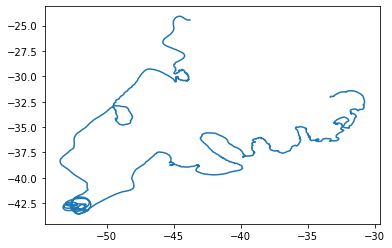

In [98]:
import matplotlib.pyplot as plt
plt.plot(x[0],y[0])

In [101]:
pad = 300234000000000
threshold = 60000000
    
for i,v in enumerate(drifter_ids):
    j = v if v < threshold else v+pad
    print(f"ID#{v}\t{gdp6h.df.loc[gdp6h.df.ID == j]['End_time'].values} - ", end='')
    print(f"{time.strftime('[%Y-%m-%dT%H:%M:%S]', time.gmtime(int(ds['end_date'][i])))}")

ID#7706884	['1990-10-03T21:21:00.000000000'] - [1990-10-03T00:00:00]
ID#7711671	['1991-10-28T08:43:00.000000000'] - [1991-10-28T00:00:00]
ID#9423473	['1996-03-02T14:50:00.000000000'] - [1996-03-02T00:00:00]
ID#9525575	['1996-06-26T23:20:00.000000000'] - [1996-06-26T00:00:00]
ID#9832423	['1999-09-18T20:43:00.000000000'] - [1999-09-18T00:00:00]
ID#9619711	['2000-04-20T16:55:00.000000000'] - [2000-04-20T00:00:00]
ID#9729733	['2000-10-09T05:00:00.000000000'] - [2000-10-09T00:00:00]
ID#9616618	['2002-08-26T03:43:00.000000000'] - [2002-08-26T00:00:00]
ID#39159	['2004-01-05T15:12:00.000000000'] - [2004-01-05T00:00:00]
ID#39235	['2004-06-05T04:24:00.000000000'] - [2004-06-05T00:00:00]
ID#39135	['2004-08-15T14:31:00.000000000'] - [2004-08-15T00:00:00]
ID#49588	['2004-11-27T06:02:00.000000000'] - [2004-11-27T00:00:00]
ID#46050	['2005-05-16T20:26:00.000000000'] - [2005-05-16T00:00:00]
ID#59324	['2007-09-15T00:11:00.000000000'] - [2007-09-15T00:00:00]
ID#71964	['2008-01-12T07:38:00.000000000'] - [

ValueError: cannot convert float NaN to integer

In [19]:
for i in drifter_ids[34:39]:
    j = i if i < threshold else i+pad
    print(gdp6h.df.loc[gdp6h.df.ID == j]['End_time'].values)

['2008-08-29T08:16:00.000000000']
['2008-11-14T21:00:00.000000000']
['2008-11-26T16:45:00.000000000']
['2008-12-22T08:47:00.000000000']
['2009-01-04T21:33:00.000000000']


## Export

In [ ]:
ra.to_parquet('../data/process/gdp_6h.parquet')
ra.to_netcdf('../data/process/gdp_6h.nc')

## Import

In [9]:
ds2 = dataformat.read_from_parquet('../data/process/gdp_6h.parquet')

In [10]:
ds2.ID

<Array [14832, 26654, ..., 67242750, 68240990] type='100 * int64[parameters...'>

## Awkward Array

In [11]:
ds = ra.to_awkward()

In [12]:
ds.ID

<Array [14832, 26654, ..., 67242750, 68240990] type='100 * int64[parameters...'>

In [13]:
ds.fields

['ID',
 'rowsize',
 'WMO',
 'expno',
 'deploy_date',
 'deploy_lat',
 'deploy_lon',
 'end_date',
 'end_lat',
 'end_lon',
 'drogue_lost_date',
 'typedeath',
 'typebuoy',
 'DeployingShip',
 'DeploymentStatus',
 'BuoyTypeManufacturer',
 'BuoyTypeSensorArray',
 'CurrentProgram',
 'PurchaserFunding',
 'SensorUpgrade',
 'Transmissions',
 'DeployingCountry',
 'DeploymentComments',
 'ManufactureYear',
 'ManufactureMonth',
 'ManufactureSensorType',
 'ManufactureVoltage',
 'FloatDiameter',
 'SubsfcFloatPresence',
 'DrogueType',
 'DrogueLength',
 'DrogueBallast',
 'DragAreaAboveDrogue',
 'DragAreaOfDrogue',
 'DragAreaRatio',
 'DrogueCenterDepth',
 'DrogueDetectSensor',
 'obs']

In [14]:
ds.obs.fields

['ids',
 'time',
 'lon',
 'lat',
 've',
 'vn',
 'temp',
 'err_lat',
 'err_lon',
 'err_temp',
 'drogue_status']